In [1]:
# ===========================================
# 05A — Single Player Anomaly Visualization
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 設定
# ------------------------------
TARGET_PLAYER = "Kaoru YAMAWAKI"

BASE03 = f"/workspace/data/03/players/{TARGET_PLAYER}"
BASE02 = f"/workspace/data/02/players/{TARGET_PLAYER}"

STATIC_LABEL_PATH  = f"{BASE03}/static_labels.parquet"
DYNAMIC_LABEL_PATH = f"{BASE03}/dynamic_labels.parquet"
ACWR_PATH          = f"{BASE02}/{TARGET_PLAYER}_acwr.parquet"

print("Loading...")
df_static = pd.read_parquet(STATIC_LABEL_PATH)      # date_, iso_anomaly, iso_score, top_features
df_dynamic = pd.read_parquet(DYNAMIC_LABEL_PATH)    # date_, dyn_error, dyn_anomaly
df_acwr = pd.read_parquet(ACWR_PATH)

print(df_static.shape, df_dynamic.shape, df_acwr.shape)


Loading...
(623, 4) (536, 3) (623, 10)


In [2]:
# ------------------------------
# ACWR 整理
# ------------------------------

acwr_cols = [c for c in df_acwr.columns if "ACWR_EWMA" in c]

def acwr_flag(x):
    if pd.isna(x): return 0
    if x > 1.5 or x < 0.8: return 1
    return 0

df_acwr_use = df_acwr[["date_"] + acwr_cols].copy()
df_acwr_use = df_acwr_use.sort_values("date_")

for col in acwr_cols:
    df_acwr_use[f"{col}_flag"] = df_acwr_use[col].apply(acwr_flag)

df_acwr_use["acwr_anomaly"] = df_acwr_use[[f"{col}_flag" for col in acwr_cols]].max(axis=1)

df_acwr_use.head()


,date_,ACWR_EWMA_total_distance,ACWR_EWMA_total_player_load,ACWR_EWMA_total_distance_flag,ACWR_EWMA_total_player_load_flag,acwr_anomaly
0,2023-01-12,NaN,NaN,0,0,0
1,2023-01-13,NaN,NaN,0,0,0
2,2023-01-14,NaN,NaN,0,0,0
3,2023-01-16,NaN,NaN,0,0,0
4,2023-01-17,NaN,NaN,0,0,0


In [3]:
# ------------------------------
# 静的ラベルを日付で合わせる
# ------------------------------
df_static_full = df_acwr_use[["date_"]].merge(df_static, on="date_", how="left")
df_static_full["iso_anomaly"] = df_static_full["iso_anomaly"].fillna(0)
df_static_full["iso_score"]   = df_static_full["iso_score"].fillna(0)
df_static_full["top_features"] = df_static_full["top_features"].fillna("").astype(str)

# ------------------------------
# 動的ラベル
# ------------------------------
df_dyn_full = df_acwr_use[["date_"]].merge(df_dynamic, on="date_", how="left")
df_dyn_full = df_dyn_full.fillna(0)


In [4]:
# ------------------------------
# 統合データフレーム
# ------------------------------
df_total = (
    df_acwr_use
    .merge(df_static_full, on="date_", how="left")
    .merge(df_dyn_full,   on="date_", how="left")
    .sort_values("date_")
)

# total anomaly score
df_total["total_anomaly_score"] = (
      df_total["iso_anomaly"]
    + df_total["dyn_anomaly"]
    + df_total["acwr_anomaly"]
)

# 強異常（説明しやすい）
df_total["strong_anomaly"] = (df_total["total_anomaly_score"] >= 2).astype(int)

df_total.head()


,date_,ACWR_EWMA_total_distance,ACWR_EWMA_total_player_load,ACWR_EWMA_total_distance_flag,ACWR_EWMA_total_player_load_flag,acwr_anomaly,iso_score,iso_anomaly,top_features,dyn_error,dyn_anomaly,total_anomaly_score,strong_anomaly
0,2023-01-12,NaN,NaN,0,0,0,0.022955,0,,0.0,0.0,0.0,0
1,2023-01-13,NaN,NaN,0,0,0,0.102804,0,,0.0,0.0,0.0,0
2,2023-01-14,NaN,NaN,0,0,0,0.010637,0,,0.0,0.0,0.0,0
3,2023-01-16,NaN,NaN,0,0,0,0.039790,0,,0.0,0.0,0.0,0
4,2023-01-17,NaN,NaN,0,0,0,0.130829,0,,0.0,0.0,0.0,0


In [5]:
# ------------------------------
# 02_daily から md_offset / md_phase を読み込んでマージ
# ------------------------------

# daily_raw を読み込む（02 の完成品）
DAILY_PATH = "/workspace/data/02/StatsAllGroup_full_players_daily.parquet"
df_daily = pd.read_parquet(DAILY_PATH)

# この選手だけ抽出
df_daily_player = df_daily[df_daily["athlete_name"] == TARGET_PLAYER][
    ["date_", "md_offset", "md_phase"]
].copy()

# 結合
df_total = df_total.merge(df_daily_player, on="date_", how="left")


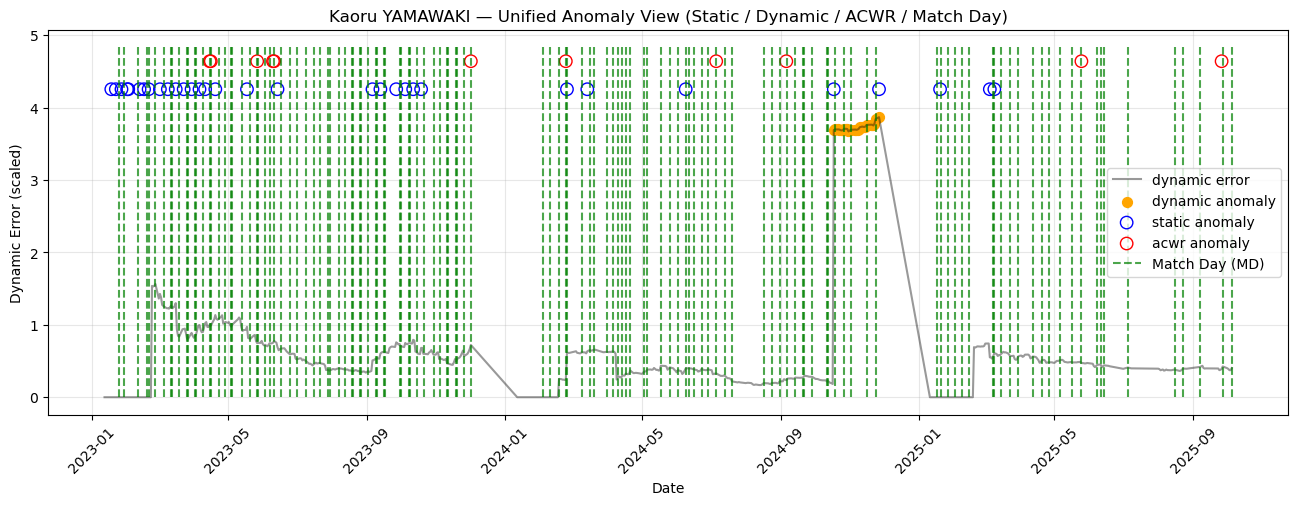

In [6]:
# ============================================================
# ★ 2. シンプル可視化：各異常と試合日を1枚に重ねる
# ============================================================

plt.figure(figsize=(16,5))

# 動的誤差
plt.plot(df_total["date_"], df_total["dyn_error"], label="dynamic error", color="black", alpha=0.4)

# 動的異常 → オレンジ
plt.scatter(
    df_total["date_"][df_total["dyn_anomaly"] == 1],
    df_total["dyn_error"][df_total["dyn_anomaly"] == 1],
    color="orange", s=50, label="dynamic anomaly"
)

# 静的異常 → 青丸
plt.scatter(
    df_total["date_"][df_total["iso_anomaly"] == 1],
    np.full(df_total["iso_anomaly"].sum(), df_total["dyn_error"].max()*1.1),
    edgecolors="blue", facecolors='none', s=80, label="static anomaly"
)

# ACWR → 赤丸
plt.scatter(
    df_total["date_"][df_total["acwr_anomaly"] == 1],
    np.full(df_total["acwr_anomaly"].sum(), df_total["dyn_error"].max()*1.2),
    edgecolors="red", facecolors='none', s=80, label="acwr anomaly"
)

# --- 試合日の線（MD = 0 の行） ---
md_mask = df_total["md_offset"] == 0
plt.vlines(
    df_total["date_"][md_mask],
    ymin=0,
    ymax=df_total["dyn_error"].max()*1.25,
    color="green",
    linestyle="--",
    alpha=0.7,
    label="Match Day (MD)"
)

plt.xlabel("Date")
plt.ylabel("Dynamic Error (scaled)")
plt.title(f"{TARGET_PLAYER} — Unified Anomaly View (Static / Dynamic / ACWR / Match Day)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [7]:
df_total.groupby("md_phase")[["dyn_anomaly", "iso_anomaly", "acwr_anomaly"]].mean()


,dyn_anomaly,iso_anomaly,acwr_anomaly
md_phase,,,
MD,0.038760,0.031008,0.062016
MD+1,0.000000,0.058824,0.000000
MD+2,0.015625,0.031250,0.000000
MD-1,0.038462,0.019231,0.028846
MD-2,0.043011,0.021505,0.000000
OTHER,0.064815,0.097222,0.000000


In [11]:
df_total.groupby("md_phase")["dyn_error"].mean()


md_phase
MD       0.623589
MD+1     0.419645
MD+2     0.577215
MD-1     0.608054
MD-2     0.633014
OTHER    0.622583
Name: dyn_error, dtype: float64